According to their website, Duff & Phelps "is the premier global valuation and corporate finance advisor with expertise in complex valuation" and other fields. According to their annual Valuation Handbook - Guide to Cost of Capital, most stock valuations react to market news with a lag.

Often, valuators use conclusions of this model to make meaningful decisions about pricing company risk.

If the model isn't true, then we will need to rethink the way we value companies -- likely in a way which increases the value of closely held businesses. They will systemically overstate the risk of publicly traded corporations and therefore understate the value of closely held firms.

If the model were true, one could utilize the predictions to almost effortlessly make untold fortunes in the stock market.

I'm publicly sharing the results of my research, so I imagine you can guess where I stand on the question.

## The Capital Asset Pricing Model

### Minimal Model

#### The Theory

In theory, all stocks have some level of correlation with the market as a whole. If the economy does well, then consumers will have more money to spend, invest, et cetera. The magnitude of this effect will vary with companies. Consumers won't spend more money at cheap grocery stores if they are richer (WMT has a beta ~0.2), but they will spend more money on construction (Construction Supply companies often have a beta ~1.6).

Rational investors, who don't want their returns to vary, will be as diversified as possible. However, they are unable to diversify the portion of a company's risk which is correlated with the market, for if the *market in general* experiences variance, then all stocks will experience variance to varying degrees.

Therefore, when investors buy a stock (a share of future income), they will pay more for future income which varies with the market less. The more a company has undiversifiable risk ("systematic risk"), the higher the return investors will have to receive in order to invest. Because expected future cash flows are discounted at this required rate of return, higher undiversifiable risk results in lower valuations.

By observing how a company's valuation changes as the market changes, practitioners are able to estimate the systematic risk of individual companies or industries. When valuing closely held businesses, which do not have extensive valuation histories, valuators will often use and adjust rates observed in comparable publicly traded companies.

#### The Practice

In a traditional Capital Asset Pricing Model ("CAPM") formulation, expected returns for security $i$ are modeled as:

$$ E[r_{i,t} - rf_{t}] = \alpha_i + \beta_i (r_{m,t} - rf_t) $$

Where $r_f$ is the risk free rate, $\beta_i$ is a measure of company $i$'s non-diversifiable risk, $\alpha_i$ is a measure of a company's extra-return and $r_{m,t}$ is the expected return of the market. All else held equal, if the risk free rate is 1.0%, the market goes up 2.0% and a company's beta is 1.5, then we would expect that company's value to increase by:

$$ 1.0\% + 1.5 ( 2.0\% - 1.0\% ) = 2.5\% $$

In an efficient market, alpha (of the website Seeking Alpha) will equal zero. Returns are calculated in excess of the risk free rate (usually the rate received on 20-year Treasury Bonds).

Coefficients can be calculated through a regression analysis of historical returns.

### The Lag Effect

To this standard theory, the Duff & Phelps textbook adds the "Lag Effect." As the 2016 Handbook describes it:

> **For all but the largest companies, the prices of individual stocks tend to react in part to movements in the overall market with a lag. The smaller the company, generally the greater the lag in the price reaction.** This does not necessarily imply that the market itself is wholly inefficient, although the market for some stocks is more efficient than for other stocks. Large companies tend to be followed by more analysts and are owned by more institutional investors than are small-cap companies. Therefore, large-cap companies tend to react more quickly to changes in the economy or changes in the business.

> Because of the lag […], traditional OLS betas tend to understate systematic risk. A sum beta consists of a multiple regression of a stock's current month's excess returns […] [and] the market's previous month's excess returns, and then a summing of the resulting coefficients. This helps to capture more fully the lagged effect of co-movement in a company's returns with returns on the market.”

The Handbook presents several examples of Sum Beta in action:

| Company | Market Cap ($MM) | OLS Beta | Sum Beta | Difference|
|:-------:|:----------------:|:--------:|:--------:|:---------:|
|AT&T, Inc.|211,690.32|0.36|0.36|0.00|
|The Boeing Company|96,872.933|1.01|1.05|0.04|
|FedEx Corporation|41,063.916|1.22|1.3|0.08|
|Lululemon Athletica Inc.|7,269.908|0.81|0.93|0.12|
|Steven Madden, Ltd.|1,891.08|1.02|1.35|0.33|
|Briggs & Stratton Corporation|765.093|1.01|1.36|0.35|
|Almost Family Inc.|375.533|1.42|1.87|0.45|
|StealthGas, Inc.|142.422|1.34|1.57|0.24|

#### Implications

Although valuators make use of the concept of beta qua the concept of beta, it is impossible to escape the predictive nature of the model. If the "sum beta" effect actually exists, then it will result in more accurate forward-looking predictions.

If the sum beta effect is statistically robust, then beating the stock market would be trivial. After periods where the market has increased in value, simply go long companies with positive beta lag coefficients and short companies with negative beta lag coefficients.

### The Details

For Duff & Phelps, periods are defined as months, but they state that weeks should give similar results. They are based on a five year historical sample. For the 2016 handbook, that is 2011 through 2015. Returns are defined as "excess returns," that is, in excess of the risk free rate. They state that using full returns (rather than excess returns) will produce similar results. Given how stable and low the risk free rate has been lately, I'm skipping this step.

The textbook doesn't state whether they use arithmetic or logarithmic returns. I assume it is the latter.

## Preparing the Environment

To analyze this question, I worked with my friend Chris White to develop a python package called White Morgan Capital Management ("WMCM"). It can be [installed from github](https://github.com/moody-marlin/wmcm). It is loaded along with several other packages below:

In [1]:
import wmcm
import math
import datetime as dt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import finsymbols
import pickle
import seaborn as sns
%matplotlib inline

## Single Stock Example -- Lululemon Athletica Inc.

First, let's recreate one of their example betas to ensure we are using their methodology correctly.

We'll start with Lululemon because they have both a high lag coefficient and market cap, and it's fun to type their name.

The object is loaded into a Universe class alongside SPY which serves as a proxy for market returns. I pulled data from November 2010 so that we could calculate the December 2010 return and know the January 2011 lag.

In [2]:
# Single stock Universe object instance created with LULU

sstock = wmcm.Universe(['LULU'], 'SPY', start='2010-11-01', end='2015-12-31', earn=False)

# Analysis_df created based on returns adjusted for dividends and splits

sstock['market'].analysis_df = sstock['market'].adj_returns
sstock['LULU'].analysis_df = sstock['LULU'].adj_returns

# Combine market data with stock data

sstock['LULU'].analysis_df = pd.merge(left = sstock['LULU'].analysis_df, right = sstock['market'].adj_returns,
                                   left_index = True, right_index = True, suffixes = ('', '_market'), how = 'left')

# Add lagged market variable

sstock['LULU'].analysis_df['lag_ret_cc_market'] = sstock['LULU'].analysis_df['ret_cc_market'].shift(1)

# Apply both models to all stocks in the portfolio and save.

sstock['LULU'].model_sr = sm.ols('ret_cc ~ ret_cc_market', data=sstock['LULU'].analysis_df).fit()
sstock['LULU'].model_mr = sm.ols('ret_cc ~ ret_cc_market + lag_ret_cc_market', data=sstock['LULU'].analysis_df).fit()

Loading the Market SPY...
Loading LULU...


In [3]:
sstock['LULU'].model_sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_cc   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     5.320
Date:                Wed, 20 Jul 2016   Prob (F-statistic):             0.0246
Time:                        10:21:11   Log-Likelihood:                 47.835
No. Observations:                  61   AIC:                            -91.67
Df Residuals:                      59   BIC:                            -87.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.0005      0.015      0.035      0.972        -0.030     0.031
ret_cc_market     0.9826      0.426      2.307      0.025         0.130     1.835
==============================================================================
Omnibus:                        0.152   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.927   Jarque-Bera (JB):                0.347
Skew:                           0.051   Prob(JB):                        0.841
Kurtosis:                       2.645   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
sstock['LULU'].model_mr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_cc   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.954
Date:                Wed, 20 Jul 2016   Prob (F-statistic):              0.151
Time:                        10:21:13   Log-Likelihood:                 48.063
No. Observations:                  60   AIC:                            -90.13
Df Residuals:                      57   BIC:                            -83.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -0.0033      0.016     -0.205      0.838        -0.035     0.029
ret_cc_market         0.8589      0.436      1.970      0.054        -0.014     1.732
lag_ret_cc_market     0.1809      0.429      0.422      0.675        -0.678     1.040
==============================================================================
Omnibus:                        0.123   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.291
Skew:                           0.080   Prob(JB):                        0.865
Kurtosis:                       2.699   Cond. No.                         32.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysis

To my eye, the model of returns which includes lagged market returns looks like a classic case of overfitting. The coefficient on lag_ret_cc_market is large enough to be worth paying attention to, but the standard error is over twice the value of the coefficient. Reaching back into my statistics 1001 textbook, we fail to reject the null hypothesis that the coefficient is equal to zero. If the coefficient were statistically significant at the 95% confidence level, then the p-value would be less than 0.05. Instead, we find a p-value at 0.675!

Judging the model as a whole, the original model has lower AIC/BIC and a higher adjusted $R^2$. These are all indicative that the model which includes the lag term is inferior.

Although including the lag term benefits the fit within the sample, this model will produce worse results out of sample.

And remember, this isn't a single stock I cherry picked to prove my point. This is a stock they cherry picked to prove their point! But to prove I'm not cherry picking results, here's the analysis repeated on all stocks everywhere.

## Expanded Universe
### Collecting Data

Tickers associated with the NYSE or NASDAQ are pulled using the finsymbols package. These are combined into a single list.

In [5]:
nyse = pd.DataFrame(finsymbols.get_nyse_symbols())
nyse['exchange'] = 'nyse'
nasdaq = pd.DataFrame(finsymbols.get_nasdaq_symbols())
nasdaq['exchange'] = 'nasdaq'
universe = pd.concat([nyse, nasdaq])
universe['symbol'] = universe['symbol'].replace('.', '-')
universe.head()

,company,industry,sector,symbol,exchange
0,3D Systems Corporation,Computer Software: Prepackaged Software,Technology,DDD,nyse
1,3M Company,Medical/Dental Instruments,Health Care,MMM,nyse
2,500.com Limited,Services-Misc. Amusement & Recreation,Consumer Services,WBAI,nyse
3,58.com Inc.,Computer Software: Programming,Technology,WUBA,nyse
4,A.H. Belo Corporation,Newspapers/Magazines,Consumer Services,AHC,nyse


Data is stored into a pickle file so it can be opened later without downloading the entire dataset. If running thise notebook for the first time, please ensure the right code block is uncommented.

In [28]:
# Uncomment these lines the first time notebook run on computer. Full price data isn't uploaded to github.
# stocks = wmcm.Universe(universe['symbol'], 'SPY', start='2010-11-01', end='2015-12-31', earn=False)
# output = open('pickle/full_history_monthly.p', 'wb')
# pickle.dump(stocks, output)
# output.close()

pkl_file = open('pickle/full_history_monthly.p', 'rb')
stocks = pickle.load(pkl_file)
pkl_file.close()

In [30]:
stocks['market']

Market Index : SPY
        Starting Date : 2010-11-01 00:00:00
        Ending Date : 2015-12-31 00:00:00
        Frequency : m

In [32]:
data_rows = len(stocks['market'].adj_returns.index)

for key in list(stocks.keys()): #list(stock.keys()) allows you to delete while iterating
    if key=='market':
        continue
    if len(stocks[key].adj_returns.index) == data_rows: # Make sure stock alive through whole period.
        stocks[key].analysis_df = stocks[key].adj_returns
        stocks[key].analysis_df = pd.merge(left = stocks[key].analysis_df, right = stocks['market'].adj_returns,
                                           left_index = True, right_index = True, suffixes = ('', '_market'), how = 'left')
        stocks[key].analysis_df['lag_ret_cc_market'] = stocks[key].analysis_df['ret_cc_market'].shift(1)
        
        stocks[key].model_sr = sm.ols('ret_cc ~ ret_cc_market', data=stocks[key].analysis_df).fit()
        stocks[key].model_mr = sm.ols('ret_cc ~ ret_cc_market + lag_ret_cc_market', data=stocks[key].analysis_df).fit()
    else:
        del stocks[key]

In [33]:
plot_data = pd.DataFrame(index=stocks.keys())

In [46]:
# plot_data['Market']

In [42]:
def get_plot_data(df):
    df['t_val'] = df.index.map(lambda x : stocks[x].model_mr.tvalues[2])
    df['market_cap'] = df.index.map(lambda x : stocks[x].market_cap)
    df['units'] = df['market_cap'].astype('str').str[-1:]
    df['market_cap'] = df['market_cap'].astype('str').str[:-1]
    
    df['new_units'] = np.nan
    df.loc[df['units'] == 'B', 'new_units'] = 1000000000
    df.loc[df['units'] == 'M', 'new_units'] = 1000000
    
    df['new_market_cap'] = pd.to_numeric(df['market_cap'], errors = 'coerce')
    
    df['new_market_cap'] = df['new_market_cap'] * df['new_units']
    
    df['market_cap'] = df['new_market_cap']
    df.drop(['units', 'new_units', 'new_market_cap'], axis = 1, inplace = True)
    df.columns = ['t_val', 'market_cap']
    
    return df

In [51]:
plot_data.drop('market', inplace=True)
plot_data = get_plot_data(plot_data)
plot_data.head()

,t_val,market_cap
USM,1.514672,3.440000e+09
EGF,0.121405,NaN
CHK,-0.009681,3.060000e+09
ELA,-0.149966,NaN
BFO,-0.411498,NaN


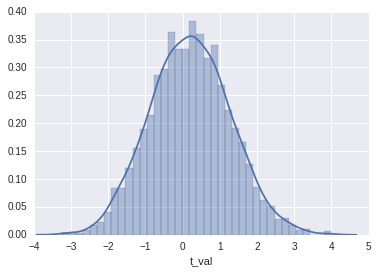

In [53]:
plot_data = plot_data.loc[plot_data['market_cap'].notnull()]
sns.distplot(plot_data['t_val'])

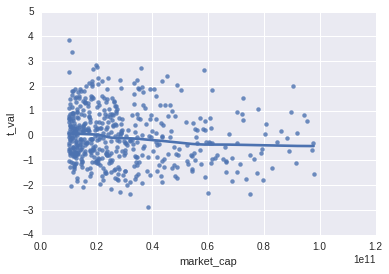

In [54]:
sns.regplot(x='market_cap', y='t_val', data=plot_data.loc[(plot_data['market_cap']<1e11) & (plot_data['market_cap']>1e10)], lowess=True)

# Scratch Space
Let's experiment with one-step ahead forecasts.

In [5]:
len(sstock['LULU'].analysis_df.index)

62

In [6]:
math.ceil(30.1)

31

In [26]:
def add_moving_forecasts(df):
    
    df['sample'] = 'test'
    df['sr_out_of_sample'] = np.nan
    df['mr_out_of_sample'] = np.nan
    
    for date in df.index:
        
        df.loc[:date, 'sample'] = 'train'
        df.loc[date, 'sample'] = 'test'
        
        try:
            sample_size = df['sample'].value_counts()['train']
        except:
            sample_size = 0

        if sample_size <= 30:
            continue
        else:
            moving_model_sr = sm.ols('ret_cc ~ ret_cc_market', data=df.loc[df['sample']=='train']).fit()
            df['sr_out_of_sample'] = moving_model_sr.predict(df.loc[df['sample']=='test'])
            moving_model_mr = sm.ols('ret_cc ~ ret_cc_market + lag_ret_cc_market', data=df.loc[df['sample']=='train']).fit()
            df['mr_out_of_sample'] = moving_model_sm.predict(df.loc[df['sample']=='test'])
    
    return df

In [27]:
add_moving_forecasts(sstock['LULU'].analysis_df)

AttributeError: 'DataFrame' object has no attribute 'design_info'

In [13]:
sstock['LULU'].analysis_df.loc[sstock['LULU'].analysis_df['sample']=='train']

,open,high,low,close,volume,ret_cc,ret_oc,ret_co,start_date,end_date,open_market,high_market,low_market,close_market,volume_market,ret_cc_market,ret_oc_market,ret_co_market,lag_ret_cc_market,sample
Date,,,,,,,,,,,,,,,,,,,,
2010-11-01,22.250000,27.384999,21.965000,26.809999,2236100,NaN,0.186433,NaN,2010-11-01,2010-11-30,105.812743,109.260741,104.497522,105.297318,200839900,NaN,-0.004883,NaN,NaN,train
2010-12-01,27.084999,37.299999,25.819999,34.209999,5009100,0.243743,0.233538,0.010205,2010-12-01,2011-01-02,107.378675,112.738675,107.369746,112.336678,127907600,0.064712,0.045139,0.019574,NaN,train
2011-01-03,34.695000,36.865001,32.650002,34.340000,3985000,0.003793,-0.010285,0.014078,2011-01-03,2011-01-31,113.194278,116.446018,112.292010,114.954140,150478100,0.023033,0.015428,0.007605,0.064712,train
2011-02-01,34.790001,42.640000,34.630001,38.794998,4721700,0.121980,0.108961,0.013019,2011-02-01,2011-02-28,115.650953,120.323083,115.579485,118.947342,155876700,0.034148,0.028104,0.006043,0.023033,train
2011-03-01,38.775002,45.485001,36.345001,44.525002,5304000,0.137760,0.138275,-0.000516,2011-03-01,2011-03-31,119.840912,119.948573,112.402999,118.961632,213912800,0.000120,-0.007364,0.007484,0.034148,train
2011-04-01,44.845001,51.415002,43.224999,50.025002,4035900,0.116472,0.109311,0.007161,2011-04-01,2011-05-01,119.697352,122.532552,116.198208,122.406929,146390600,0.028550,0.022384,0.006165,0.000120,train
2011-05-02,50.134999,50.570000,44.025002,45.400002,3865200,-0.097011,-0.099207,0.002196,2011-05-02,2011-05-31,122.981162,123.079843,117.876011,121.034195,166778000,-0.011278,-0.015958,0.004680,0.028550,train
2011-06-01,45.075001,57.099998,41.180000,55.910000,5085400,0.208231,0.215415,-0.007184,2011-06-01,2011-06-30,121.282595,121.652279,113.780771,118.992378,224261600,-0.017014,-0.019064,0.002050,-0.011278,train
2011-07-01,111.820000,123.839996,58.529999,60.540001,3407500,0.079561,-0.613586,0.693147,2011-07-01,2011-07-31,119.100575,122.355577,115.385730,116.611992,207390300,-0.020207,-0.021116,0.000909,-0.017014,train
